# Fit the topic model
* Load the tokenized corpus created in 00_load_data
* Fit the LDA model on the train corpus, evaluate it on the validate corpus
* Save the fitted model

## References
* [LDA implementation from gensim library](https://radimrehurek.com/gensim/models/ldamodel.html)
* [Original LDA paper](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)

In [1]:
from gensim.models import LdaModel
from gensim import corpora
from gensim.parsing.preprocessing import preprocess_string
import pandas as pd
import pickle
import numpy as np
import statistics
import os
from matplotlib import pyplot as plt 
    
%matplotlib inline

In [2]:
DATA_PATH = '../data'
MODELS_PATH = '../models'

## Load dictionary and corpus

Load the dictionary and tokenized train-, validate and test- corpura created in 01_prepare_data.

In [3]:
with open(os.path.join(DATA_PATH, 'dictionary.pickle'), 'rb') as handle:
    dictionary = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_train.pickle'), 'rb') as handle:
    corpus_train = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_validate.pickle'), 'rb') as handle:
    corpus_validate = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_test.pickle'), 'rb') as handle:
    corpus_test = pickle.load(handle)

## Fit the model
Fit the model on the training set, for different number of topics (k).
Validate the model by computing perplexity for different values of k. The best value for k is that which yields a perplexity closest to 0.

Use the train dataset to fit the model, use the validate dataset to compute perplexity and tune the value of k.

Since LDA has a random component, the best k might vary between runs. Therefore the model is fitted several times and the best value is compiled from all runs (mode of best k for all runs).

see: https://radimrehurek.com/gensim/models/ldamodel.html

In [4]:
# parameters passed to the compute_perplexity_for_lda function
min_k = 2    # at least 2 topics
max_k = 12   # at most 12 topics
max_runs = 5 # repeat max_runs times

In [5]:
def compute_perplexity_for_lda(dictionary, corpus_train, corpus_validate, min_k, max_k, max_runs):
    """A function to train a LDA model"""
    perplexity = []
    for run in range(max_runs):
        print(f"Run {run + 1} / {max_runs}")
        px = []
        num_topics = []
        for k in range(min_k, max_k + min_k):
            # Define the LDA model
            ldamodel = LdaModel(corpus_train, num_topics=k, id2word=dictionary, passes=15)
            num_topics.append(k)
            log_perplexity = ldamodel.log_perplexity(corpus_validate)
            perplexity_k = np.exp(-log_perplexity)
            px.append(perplexity_k)
        perplexity.append(pd.DataFrame.from_dict({'k': num_topics, 'val': px}))
    return(perplexity)

In [6]:
%%time

perplexity = compute_perplexity_for_lda(dictionary, corpus_train, corpus_validate, min_k, max_k, max_runs)

Run 1 / 5
Run 2 / 5
Run 3 / 5
Run 4 / 5
Run 5 / 5
CPU times: user 1h 50min 4s, sys: 343 ms, total: 1h 50min 4s
Wall time: 1h 50min 4s


### Preplexity curve

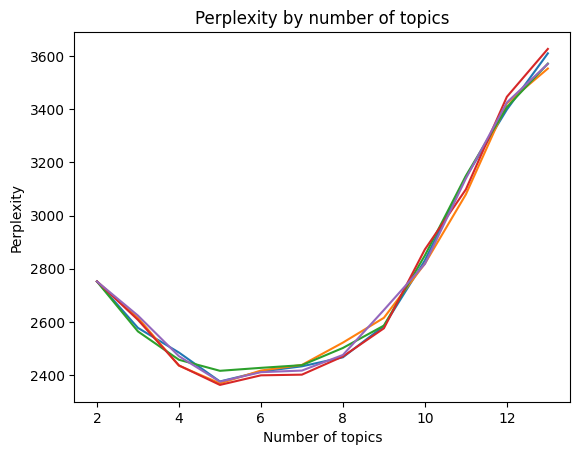

In [7]:
for run in range(max_runs):
    plt.plot(perplexity[run].k, perplexity[run].val)
plt.title("Perplexity by number of topics")
plt.xlabel("Number of topics")
plt.ylabel("Perplexity")
plt.show()

### Find the best k value: mode of list of best values for each run

In [8]:
def find_best_k(max_runs, perplexity):
    best_k_runs = []
    for run in range(max_runs):
        best_k_runs.append(perplexity[run].sort_values('val', ascending=True).iloc[0]['k'])
    best_k = statistics.mode(best_k_runs)
    return(best_k)

In [9]:
best_k = find_best_k(max_runs, perplexity)
print(f"Best number of topics after {max_runs} runs is: {best_k}")

Best number of topics after 5 runs is: 5.0


### Save the model
Refit the model using best number of topics, save it.

In [10]:
ldamodel = LdaModel(corpus_train, num_topics=best_k, id2word=dictionary, passes=15)

Print the topics, with top words

In [11]:
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.008*"material" + 0.007*"high" + 0.006*"energy" + 0.006*"property" + 0.005*"optical"')
(1, '0.013*"model" + 0.010*"theory" + 0.008*"field" + 0.008*"equation" + 0.007*"energy"')
(2, '0.012*"star" + 0.010*"mass" + 0.010*"galaxy" + 0.007*"model" + 0.006*"observation"')
(3, '0.034*"quantum" + 0.012*"state" + 0.010*"model" + 0.009*"method" + 0.007*"time"')
(4, '0.016*"spin" + 0.015*"state" + 0.014*"phase" + 0.014*"magnetic" + 0.012*"field"')


In [12]:
with open(os.path.join(MODELS_PATH, 'topic_model.pickle'), 'wb') as handle:
    pickle.dump(ldamodel, handle, protocol=pickle.HIGHEST_PROTOCOL)